# SleepDB Dataset Creation
In this notebook, we create TS for the TSSB from the SleepDB data archive.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import sys
import mne
sys.path.append("../")

from tqdm import tqdm
from src.visualizer import plot_ts

First, we need to download the mHealth data archive from https://physionet.org/content/sleep-edfx/1.0.0/ and place it into the DATA_PATH folder.

In [3]:
DATA_PATH = "../archives/SleepDB/"

Now, we define a helper procedure to extract change points from a series of activities.

In [193]:
def extract_cps(activities):
    cps = list()

    for idx in range(1, len(activities)):
        if activities[idx-1] != activities[idx]:
            cps.append(idx)

    return np.array(cps, dtype=np.int64)

Let's write the function to load the request time series with annotated change points.

In [348]:
def load_sleep_ts(signal, annotation, resample_rate=1):
    df = []

    rec = mne.io.read_raw_edf(DATA_PATH + "sleep-cassette/" + signal + ".edf")
    ann = mne.read_annotations(DATA_PATH + "sleep-cassette/" + annotation + ".edf")
    
    cps, desc = [], []
    
    for cp, stage in zip(ann.onset, ann.description):
        if stage.endswith("W"):
            cps.append(cp)
            desc.append("W")
            continue
            
        if any(str(num) in stage for num in (1,2,3,4)):
            cps.append(cp)
            desc.append(f"S")
            continue
            
        if stage.endswith("R"):
            cps.append(cp)
            desc.append("S")
            continue
            
    cps = np.asarray(cps, dtype=np.int64)[extract_cps(desc)]
    cps = cps * 100
    
    for idx, sensor in enumerate(rec.ch_names):
        name = f"SleepDB Subject{signal} {sensor}"
        ts = rec.get_data()[idx,:]
        df.append((name.replace(" ", "_"), cps, ts))
        
    return pd.DataFrame.from_records(df, columns=["name", "change_points", "time_series"])

Now, let's load the subject data, explore it and create annotated TS.

In [349]:
df = load_sleep_ts("SC4001E0-PSG", "SC4001EC-Hypnogram")

Extracting EDF parameters from /Users/ermshaua/Documents/Git/online-clasp/archives/SleepDB/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

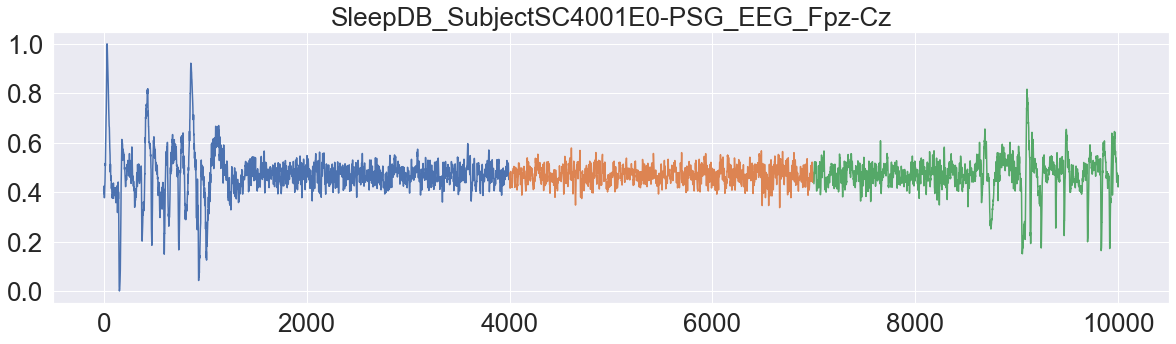

In [432]:
selection = 0
name, cps, ts = df.iloc[selection, :].tolist()

start, end = 5150000, 5150000 + 10_000 # 5300000
ts = ts[start:end] 
cps = cps[np.logical_and(cps > start, cps < end)] - start

# bandpass filter
from scipy import signal
firwin = signal.firwin(100, [.01, .6], pass_zero=False) # 1000 .005, .05
ts = signal.convolve(ts, firwin, mode='same')

# 50 Hz filter
# ts = ts[::2]
# cps = np.asarray(cps / 2, dtype=np.int64)

ts = (ts - ts.min()) / (ts.max() - ts.min())

plot_ts(
    name,
    ts,
    cps,
    show=True
)

Finally, let's save the TS and display the annotated CPs.

In [427]:
print(f"{name},100,{','.join(dp.map(str, cps))}")
np.savetxt(f"../datasets/VLTS/{name}.txt", ts)

SleepDB_SubjectSC4001E0-PSG_Resp_oro-nasal,100,4000,7000,61000,76000
